<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/pytorch_timeseries_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2021-06-22 10:04:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2021-06-22 10:04:48 (49.8 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

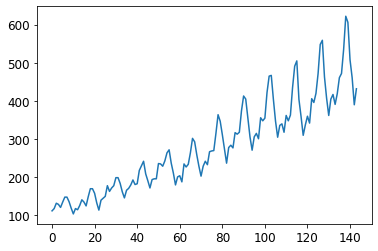

In [ ]:
airline_data=pd.read_csv("airline-passengers.csv")
features=airline_data['Passengers'].values
plt.plot(features)

In [ ]:
def sliding_windows(data,seq_lenght):
  x=[]
  y=[]
  for i in range(len(data)-seq_lenght-1):
    _x=data[i:(i+seq_lenght)]
    _y=data[i+seq_lenght]
    x.append(_x)
    y.append(_y)
  return np.array(x),np.array(y)

In [ ]:
sc = MinMaxScaler()
training_data = sc.fit_transform(features.reshape(-1,1))

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

In [ ]:
trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
trainX.shape

torch.Size([93, 4, 1])

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(self.hidden_size*num_layers,self.num_classes)
    def forward(self,x):
      h0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
      c0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
      ula,(hout,cout)=self.lstm(x,(h0,c0))
      hout=hout.view(-1,self.hidden_size*num_layers)
      out=self.fc(hout)
      return out

In [ ]:
from torchsummary import summary

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.11072
Epoch: 100, loss: 0.01604
Epoch: 200, loss: 0.00264
Epoch: 300, loss: 0.00200
Epoch: 400, loss: 0.00176
Epoch: 500, loss: 0.00172
Epoch: 600, loss: 0.00171
Epoch: 700, loss: 0.00171
Epoch: 800, loss: 0.00170
Epoch: 900, loss: 0.00168
Epoch: 1000, loss: 0.00167
Epoch: 1100, loss: 0.00165
Epoch: 1200, loss: 0.00163
Epoch: 1300, loss: 0.00161
Epoch: 1400, loss: 0.00161
Epoch: 1500, loss: 0.00160
Epoch: 1600, loss: 0.00160
Epoch: 1700, loss: 0.00159
Epoch: 1800, loss: 0.00159
Epoch: 1900, loss: 0.00159


In [ ]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

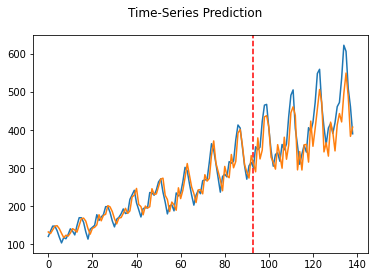

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

# GRU

In [ ]:
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.GRU=nn.GRU(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(self.hidden_size,self.num_classes)
    def forward(self,x):
      h0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
      c0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
      ula,hout=self.GRU(x,h0)
      hout=hout.view(-1,self.hidden_size*num_layers)
      out=self.fc(hout)
      return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

gru = GRU(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    outputs = gru(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.02710
Epoch: 100, loss: 0.00286
Epoch: 200, loss: 0.00201
Epoch: 300, loss: 0.00182
Epoch: 400, loss: 0.00176
Epoch: 500, loss: 0.00174
Epoch: 600, loss: 0.00172
Epoch: 700, loss: 0.00170
Epoch: 800, loss: 0.00168
Epoch: 900, loss: 0.00167
Epoch: 1000, loss: 0.00165
Epoch: 1100, loss: 0.00164
Epoch: 1200, loss: 0.00163
Epoch: 1300, loss: 0.00162
Epoch: 1400, loss: 0.00160
Epoch: 1500, loss: 0.00159
Epoch: 1600, loss: 0.00157
Epoch: 1700, loss: 0.00159
Epoch: 1800, loss: 0.00156
Epoch: 1900, loss: 0.00160


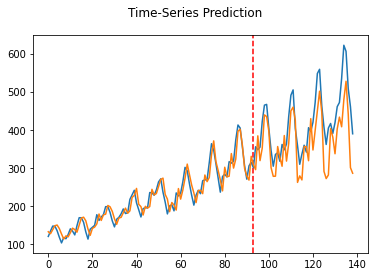

In [ ]:
lstm.eval()
train_predict = gru(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

# Another Example

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
series.shape

(10000, 60, 1)

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)


In [ ]:
seq_length = 4
train_size = int(len(series) * 0.67)
test_size = len(series) - train_size

In [ ]:
X_train=series[:,:50,:]
Y_train=series[:,50:60,:].reshape(-1,10*1)

In [ ]:
Y_train.shape

(10000, 10)

In [ ]:
trainX = Variable(torch.Tensor(np.array(X_train[0:train_size]))).to(device)
trainY = Variable(torch.Tensor(np.array(Y_train[0:train_size]))).to(device)

In [ ]:
trainY.shape

torch.Size([93, 10])

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(self.hidden_size*self.num_layers,self.num_classes)
    def forward(self,x):
      h0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size)).cuda()
      c0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size)).cuda()
      ula,(hout,_)=self.lstm(x,(h0,c0))
      hout=hout.view(-1,self.hidden_size*self.num_layers)
      out=self.fc(hout)
      return out

In [ ]:
num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 10
num_layers = 1

num_classes = 10

lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [ ]:
def train():

  lstm.train()
  optimizer.zero_grad()
  random=np.random.randint(0,len(trainX),32)
  outputs = lstm(trainX[random])
  
    
    # obtain the loss function
  loss = criterion(outputs, trainY[random])
    
  loss.backward()
    
  optimizer.step()
  return loss,accuracy

In [ ]:
for epoch in range(num_epochs):

    loss,acc=train()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f, accuracy:%1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.14727
Epoch: 100, loss: 0.11804
Epoch: 200, loss: 0.05456
Epoch: 300, loss: 0.04173
Epoch: 400, loss: 0.05144
Epoch: 500, loss: 0.04370
Epoch: 600, loss: 0.03362
Epoch: 700, loss: 0.03493
Epoch: 800, loss: 0.03711
Epoch: 900, loss: 0.03147
Epoch: 1000, loss: 0.03448
Epoch: 1100, loss: 0.03456
Epoch: 1200, loss: 0.03369
Epoch: 1300, loss: 0.03883
Epoch: 1400, loss: 0.03410
Epoch: 1500, loss: 0.04373
Epoch: 1600, loss: 0.03474
Epoch: 1700, loss: 0.02635
Epoch: 1800, loss: 0.03096
Epoch: 1900, loss: 0.03004


In [ ]:
testX = Variable(torch.Tensor(np.array(X_train[train_size:len(series)]))).cuda()
testY = Variable(torch.Tensor(np.array(Y_train[train_size:len(series)]))).cuda()

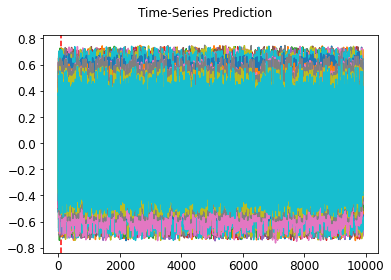

In [ ]:
train_predict = lstm(testX)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = testY.cpu().data.numpy()

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.GRU=nn.GRU(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(self.hidden_size*self.num_layers,self.num_classes)
    def forward(self,x):
      h0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size)).cuda()
      c0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size)).cuda()
      ula,hout=self.GRU(x,h0)
      hout=hout.view(-1,self.hidden_size*num_layers)
      out=self.fc(hout)
      return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 10

gru = GRU(num_classes, input_size, hidden_size, num_layers).cuda()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    random=np.random.randint(0,len(trainX),32)
    outputs = gru(trainX[random])
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY[random])
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.25079
Epoch: 100, loss: 0.14019
Epoch: 200, loss: 0.09922
Epoch: 300, loss: 0.08827
Epoch: 400, loss: 0.08925
Epoch: 500, loss: 0.06228
Epoch: 600, loss: 0.06025
Epoch: 700, loss: 0.04544
Epoch: 800, loss: 0.04501
Epoch: 900, loss: 0.03827
Epoch: 1000, loss: 0.04035
Epoch: 1100, loss: 0.05494
Epoch: 1200, loss: 0.04378
Epoch: 1300, loss: 0.04877
Epoch: 1400, loss: 0.03907
Epoch: 1500, loss: 0.04717
Epoch: 1600, loss: 0.04267
Epoch: 1700, loss: 0.04930
Epoch: 1800, loss: 0.03928
Epoch: 1900, loss: 0.03447


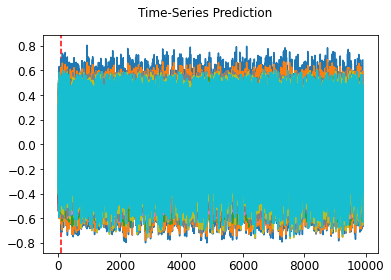

In [ ]:
train_predict = gru(testX)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = testY.cpu().data.numpy()

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
class Conv_GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(Conv_GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.conv1=nn.Conv1d(input_size,20,2,padding="same")
        self.conv2=nn.Conv1d(20,30,2,padding="same")
        self.relu=nn.ReLU()
        self.batchnorm1=nn.BatchNorm1d(20)
        self.batchnorm2=nn.BatchNorm1d(30)
        self.GRU=nn.GRU(input_size=1,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(self.hidden_size*num_layers,self.num_classes)
    def forward(self,x):
      x=self.relu(self.conv1(x))
      x=self.batchnorm1(x)
      x=self.relu(self.conv2(x))
      x=self.batchnorm2(x)
      h0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size)).cuda()
      c0=Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size)).cuda()
      ula,hout=self.GRU(x,h0)
      hout=hout.view(-1,self.hidden_size*num_layers)
      out=self.fc(hout)
      return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 50
hidden_size = 2
num_layers = 1

num_classes = 1

gru = Conv_GRU(num_classes, input_size, hidden_size, num_layers).cuda()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    random=np.random.randint(0,len(trainX),32)
    outputs = gru(trainX[random])
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY[random])
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 10])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.31005
Epoch: 100, loss: 0.07176
Epoch: 200, loss: 0.07570
Epoch: 300, loss: 0.07675
Epoch: 400, loss: 0.07591
Epoch: 500, loss: 0.07336
Epoch: 600, loss: 0.09589
Epoch: 700, loss: 0.06976
Epoch: 800, loss: 0.06962
Epoch: 900, loss: 0.07781
Epoch: 1000, loss: 0.05894
Epoch: 1100, loss: 0.07384
Epoch: 1200, loss: 0.06325
Epoch: 1300, loss: 0.06319
Epoch: 1400, loss: 0.07794
Epoch: 1500, loss: 0.08497
Epoch: 1600, loss: 0.07118
Epoch: 1700, loss: 0.07843
Epoch: 1800, loss: 0.06690
Epoch: 1900, loss: 0.07965


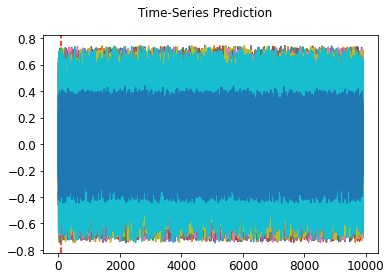

In [ ]:
train_predict = gru(testX)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = testY.cpu().data.numpy()

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()